### Шаг 1. Загрузка данных

### Импорт библиотек

In [1]:
!pip install shap --quiet
!pip install --upgrade scikit-learn matplotlib numpy shap --quiet

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import re

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка данных

In [4]:
try:
    market_file = pd.read_csv('datasets/market_file.csv')
    market_money = pd.read_csv('datasets/market_money.csv')
    market_time = pd.read_csv('datasets/market_time.csv')
    money = pd.read_csv('datasets/money.csv', sep=';', decimal=',')
except FileNotFoundError:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

In [5]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [7]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [9]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [11]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [12]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


#### Промежуточный вывод
В таблице money использован separator и decimal, чтобы корректно считать данные. Данные в таблицах market_file, market_money, market_time и money загружены корректно. Переходим к предобработке данных.

### Предобработка данных

In [13]:
money['Прибыль'] = money['Прибыль'] * 1000

money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3996.630769
std,375.421985,1013.722112
min,215348.000000,860.000000
25%,215672.750000,3300.000000
50%,215997.500000,4045.000000
75%,216322.250000,4670.000000
max,216647.000000,7430.000000


Домножили столбец "Прибыль" на 1000, чтобы прибыль была в рублях

In [14]:
# market_file
print(f'Количество дубликатов в market_file: {market_file.duplicated().sum()}')

# market_money
print(f'Количество дубликатов в market_money: {market_money.duplicated().sum()}')

# market_time
print(f'Количество дубликатов в market_time: {market_time.duplicated().sum()}')

# money
print(f'Количество дубликатов в money: {money.duplicated().sum()}')

Количество дубликатов в market_file: 0
Количество дубликатов в market_money: 0
Количество дубликатов в market_time: 0
Количество дубликатов в money: 0


Обработка неявных дубликатов

In [15]:
market_file.loc[market_file['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'
market_time.loc[market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'

In [16]:
def clean_column_names(column_names):
    new_column_names = []
    for col in column_names:
        # 1. Заменяем пробелы на подчеркивания
        col = re.sub(r'\s+', '_', col)
        # 2. Заменяем дефисы и прочие разделители на подчеркивания
        col = re.sub(r'[-—]', '_', col)
        # 3. Удаляем лишние символы (скобки, точки)
        col = re.sub(r'[()\.]', '', col)
        # 4. Приводим все буквы к нижнему регистру
        col = col.lower()
        new_column_names.append(col)
    
    return new_column_names

In [17]:
market_file.columns = clean_column_names(market_file.columns)
market_money.columns = clean_column_names(market_money.columns)
market_time.columns = clean_column_names(market_time.columns)
money.columns = clean_column_names(money.columns)

In [18]:
display(market_file.columns)
display(market_money.columns)
display(market_time.columns)
display(money.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

Index(['id', 'период', 'выручка'], dtype='object')

Index(['id', 'период', 'минут'], dtype='object')

Index(['id', 'прибыль'], dtype='object')

### Исследовательский анализ данных

#### Анализ таблицы market_file

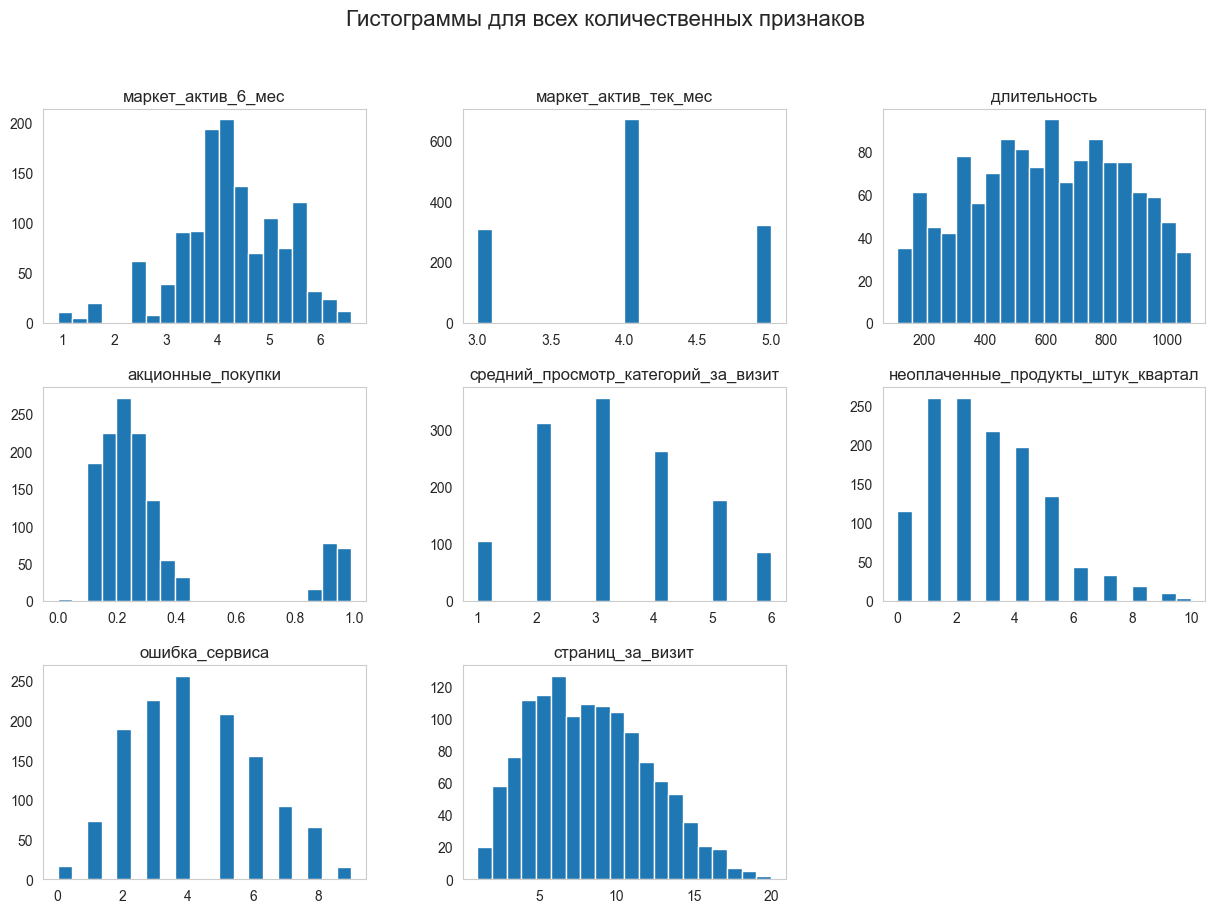

In [19]:
# Построим гистограммы для всех количественных признаков
market_file.drop('id', axis=1).hist(figsize=(15, 10), bins=20, grid=False);
plt.suptitle('Гистограммы для всех количественных признаков', fontsize=16);

Маркет актив 6 мес - больше всего людям приходило 4 маркетинговых сообщения за последние 6 месяцев. <br>
Маркет актив текущий месяц - людям пришло от 3 до 5 маркетинговых сообщений. Больше всего пришло 4 сообщения.<br>
Длительность - большинство людей провели на сайте от 0 до 800 секунд.<br>
Акционные покупки - больше всего процентов приходится на 20-30% акционных покупок.<br>
Средний просмотр категорий за визит - больше всего люди просматривают 2-3 категории за визит.<br>
Неоплаченные продукты штук квартал - больше всего люди не оплачивают 1-2 продукта за квартал.<br>
Ошибка сервиса - больше всего люди сталкиваются с 4 ошибками сервиса.<br>
Страниц за визит - больше всего люди просматривают 6-7 страниц за визит.

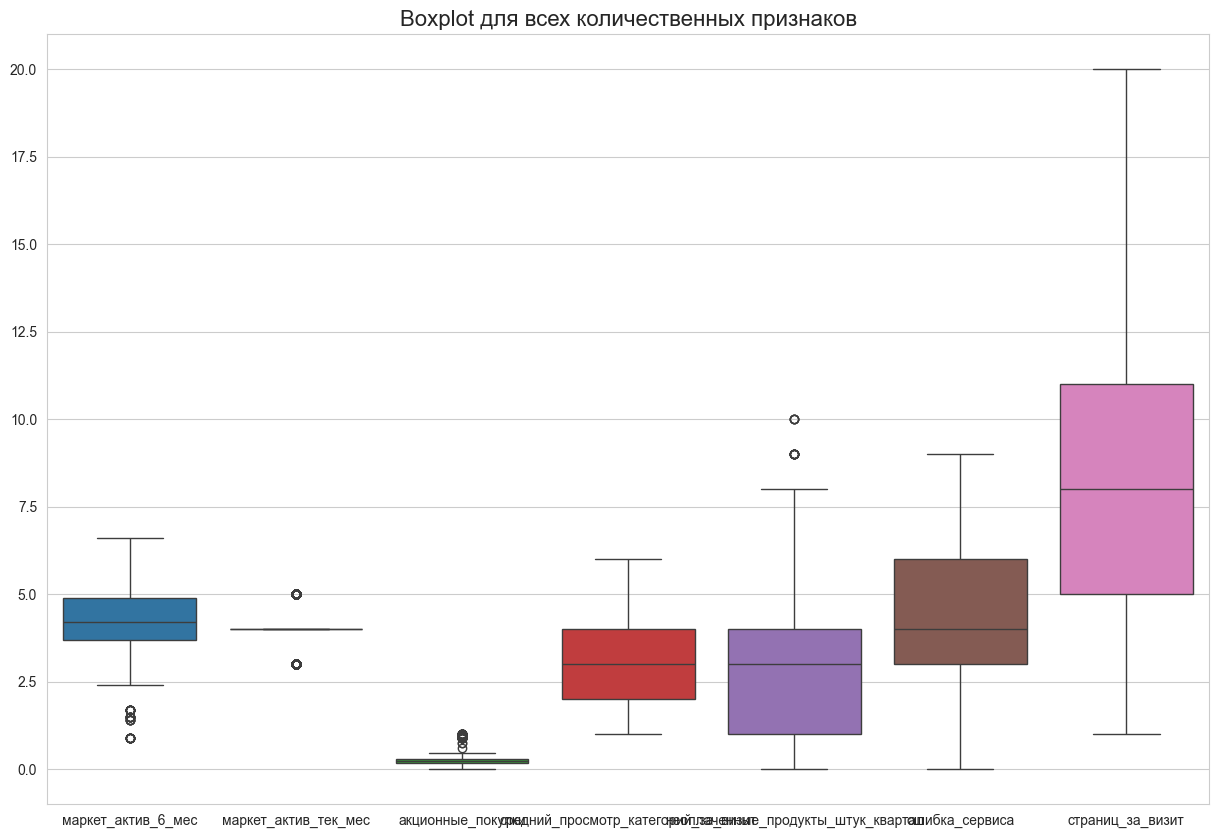

In [20]:
# Построим boxplot для market_file (кроме id и длительности)
plt.figure(figsize=(15, 10))
sns.boxplot(data=market_file.drop(['id', 'длительность'], axis=1));
plt.title('Boxplot для всех количественных признаков', fontsize=16);

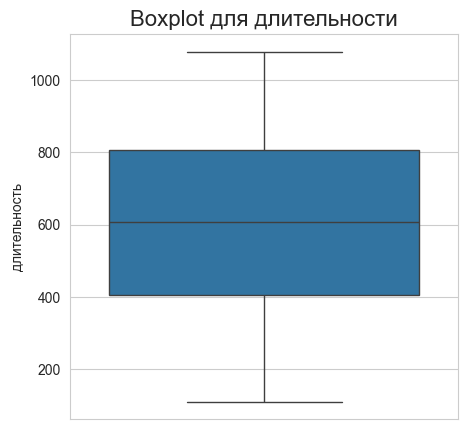

In [21]:
# Построим boxplot для длительности
plt.figure(figsize=(5, 5))
sns.boxplot(data=market_file['длительность']);
plt.title('Boxplot для длительности', fontsize=16);

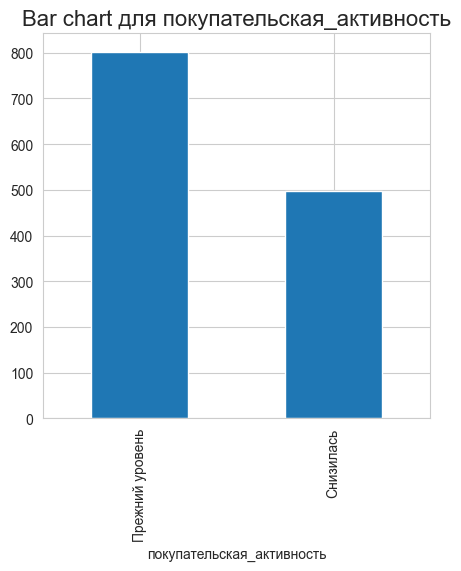

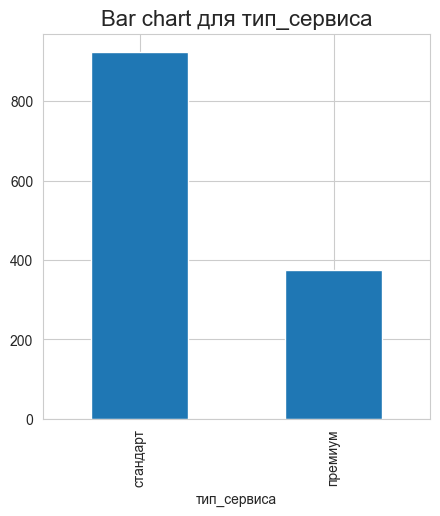

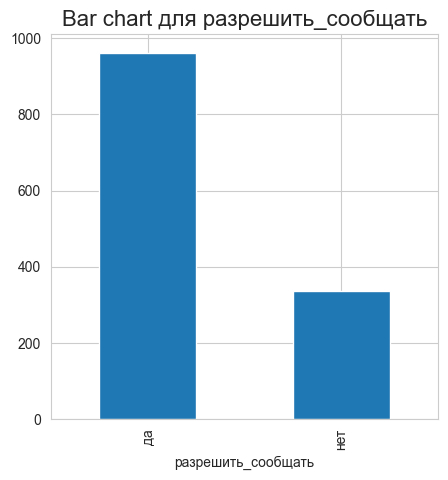

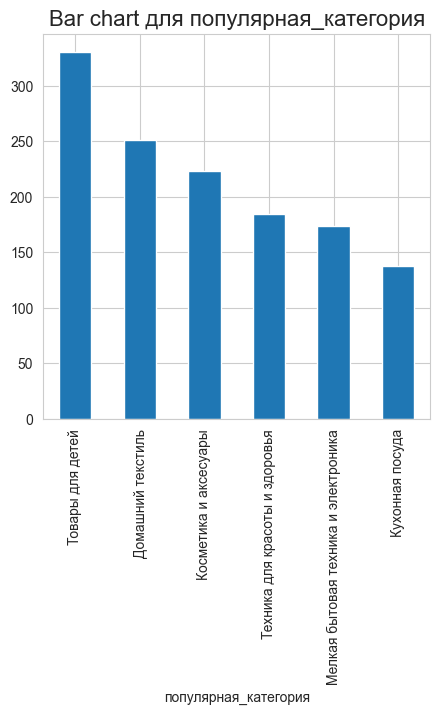

In [22]:
# Анализ категориальных признаков
for column in market_file.select_dtypes(include='object').columns:
    plt.figure(figsize=(5, 5))
    market_file[column].value_counts().plot(kind='bar');
    plt.title(f'Bar chart для {column}', fontsize=16);
    plt.show();

#### Анализ таблицы market_money

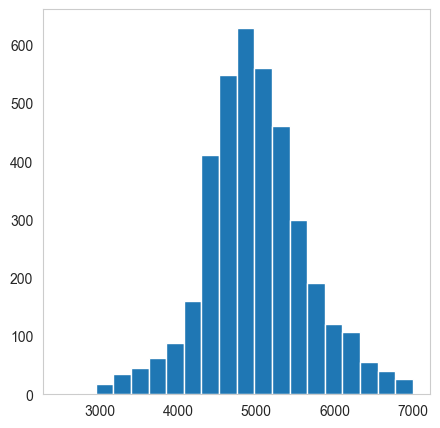

In [23]:
# Построим гистограммы для выручки (единственного количественного признака)
market_money['выручка'].hist(figsize=(5, 5), bins=20, grid=False, range=(2500, 7000));

Пик выручки приходится на 5000 рублей.

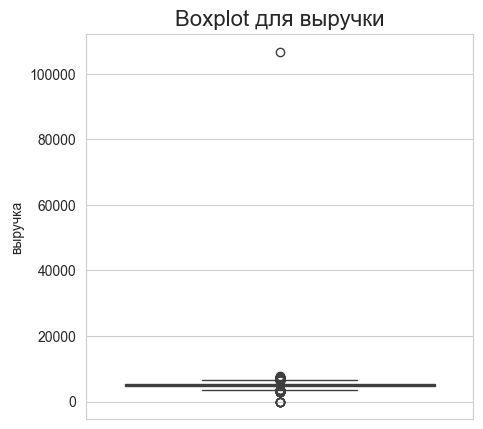

In [24]:
# Построим boxplot для выручки
plt.figure(figsize=(5, 5))
sns.boxplot(data=market_money['выручка']);
plt.title('Boxplot для выручки', fontsize=16);

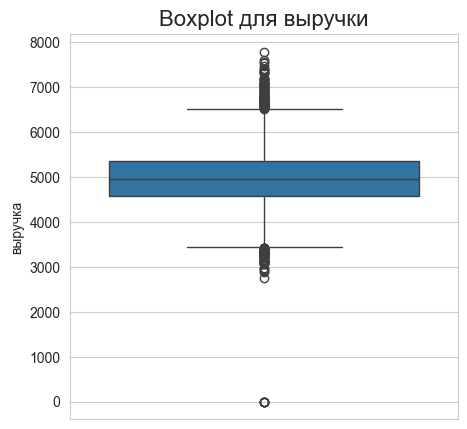

In [25]:
# Удалим выброс и построим boxplot ещё раз
market_money = market_money.query('выручка < 100000')
plt.figure(figsize=(5, 5))
sns.boxplot(data=market_money['выручка']);
plt.title('Boxplot для выручки', fontsize=16);

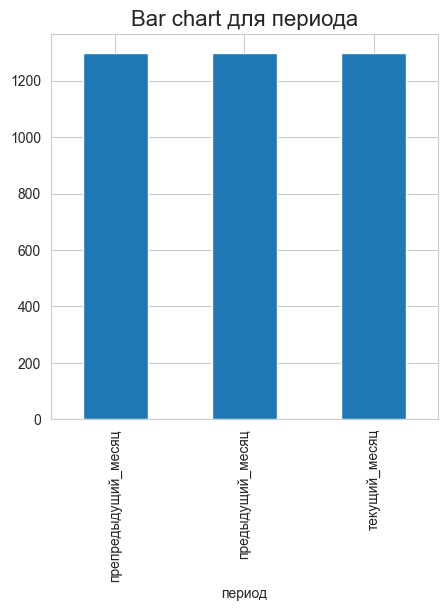

In [26]:
# Анализ периода (категориального признака)
plt.figure(figsize=(5, 5))
market_money['период'].value_counts().plot(kind='bar');
plt.title('Bar chart для периода', fontsize=16);

#### Анализ таблицы market_time

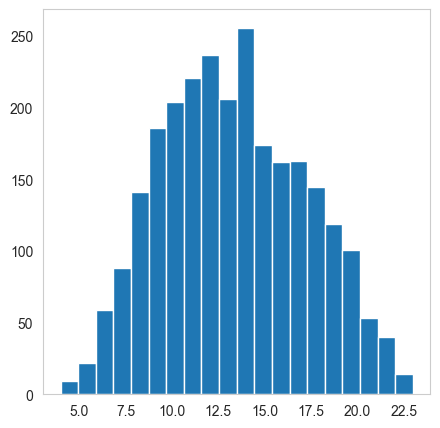

In [27]:
# Построим гистограмму для минут проведённых на сайте
market_time['минут'].hist(figsize=(5, 5), bins=20, grid=False);

Среднее время проведённое на сайте - от 10 до 15 минут

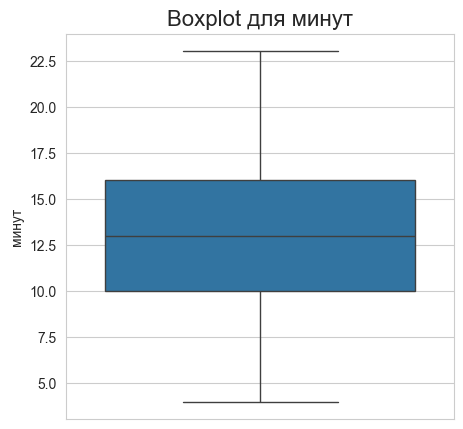

In [28]:
# Построим boxplot для минут
plt.figure(figsize=(5, 5))
sns.boxplot(data=market_time['минут']);
plt.title('Boxplot для минут', fontsize=16);

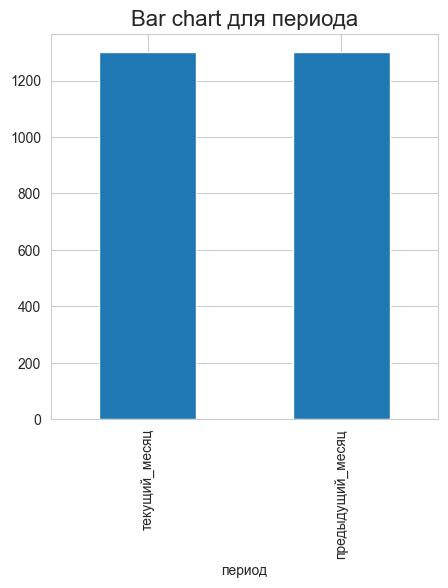

In [29]:
# Анализ периода (категориального признака)
plt.figure(figsize=(5, 5))
market_time['период'].value_counts().plot(kind='bar');
plt.title('Bar chart для периода', fontsize=16);

#### Анализ таблицы money

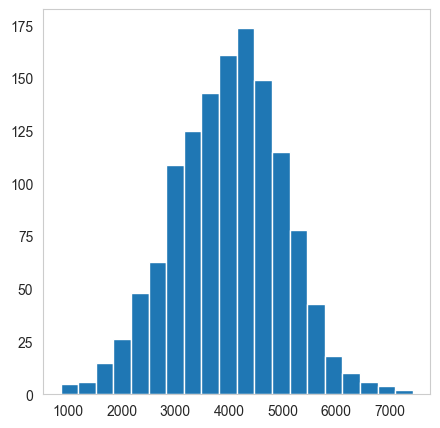

In [30]:
# Построим гистограмму для прибыли
money['прибыль'].hist(figsize=(5, 5), bins=20, grid=False);

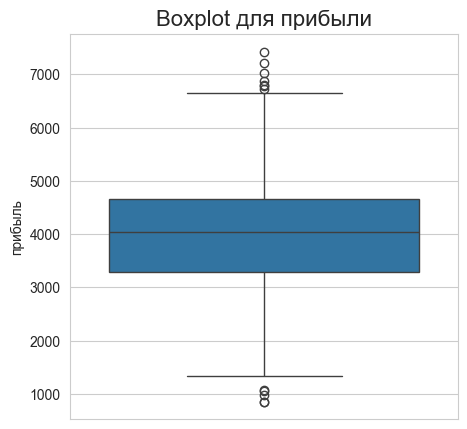

In [31]:
# Построим boxplot для прибыли
plt.figure(figsize=(5, 5))
sns.boxplot(data=money['прибыль']);
plt.title('Boxplot для прибыли', fontsize=16);

#### Отберём только клиентов с покупательской активностью не менее трёх месяцев

In [32]:
required_periods = ['текущий_месяц', 'предыдущий_месяц', 'препредыдущий_месяц']

market_money_filtered = market_money[market_money['выручка'] > 0]
client_periods_with_revenue = market_money_filtered.groupby('id')['период'].nunique().reset_index(name='num_periods')
active_clients_3_months = client_periods_with_revenue[client_periods_with_revenue['num_periods'] == 3]

active_clients_3_months.head()

,id,num_periods
1,215349,3
2,215350,3
3,215351,3
4,215352,3
5,215353,3


### Объединение таблиц

In [33]:
# Создаем таблицы с выручкой и временем
market_money_pivot = market_money.pivot(index='id', columns='период', values='выручка').reset_index()
market_money_pivot.columns = ['id', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц']

market_time_pivot = market_time.pivot(index='id', columns='период', values='минут').reset_index()
market_time_pivot.columns = ['id', 'минут_текущий_месяц', 'минут_предыдущий_месяц']

active_clients_ids = active_clients_3_months['id']

market = market_file.merge(market_money_pivot, on='id', how='inner') \
    .merge(market_time_pivot, on='id', how='inner')

# Фильтруем по активным клиентам
market = market[market['id'].isin(active_clients_ids)]

market

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


### Корреляционный анализ

In [34]:
quantitative_columns = market.select_dtypes(include=['float64', 'int64']).columns
quantitative_columns = quantitative_columns.drop('id')
quantitative_columns

Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'минут_текущий_месяц',
       'минут_предыдущий_месяц'],
      dtype='object')

In [35]:
category_columns = market.select_dtypes(include='object').columns
category_columns

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'популярная_категория'],
      dtype='object')

In [36]:
market_corr = market[quantitative_columns].corr(method='spearman')

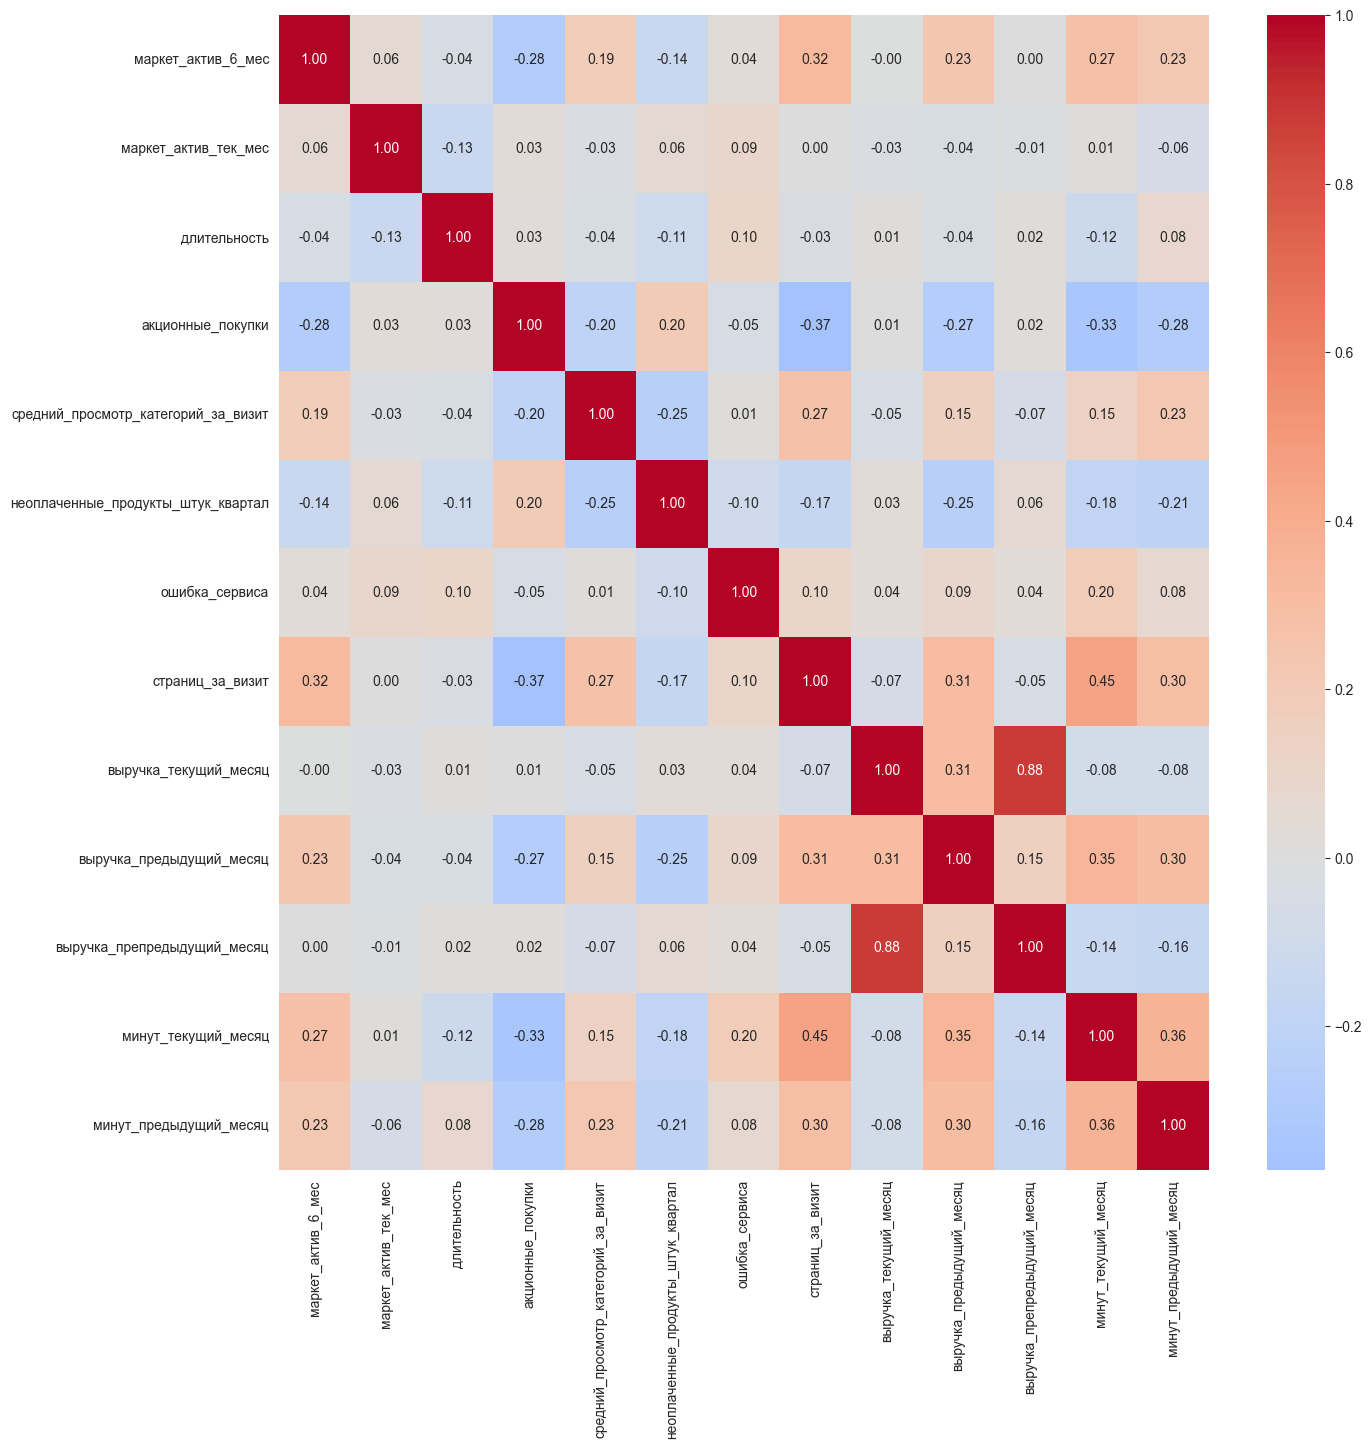

In [37]:
plt.figure(figsize=(15, 15))
sns.heatmap(market_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0);

Мультиколлинеарность наблюдается между выручкой в текущем месяце и выручкой в препредыдущем мсяце.Удалим препредыдущий месяц из тренировочной выборки.

### Использование пайплайнов

In [38]:
# Преобразуем значения активности
market['покупательская_активность'] = market['покупательская_активность'].map({
    'Снизилась': 1,
    'Прежний уровень': 0
})
market['покупательская_активность'] = market['покупательская_активность'].astype('int8')

market['покупательская_активность'].value_counts()

покупательская_активность
0    802
1    494
Name: count, dtype: int64

In [39]:
X = market.drop(['id', 'покупательская_активность', 'выручка_препредыдущий_месяц'], axis=1)
y = market['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [40]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (972, 15)
X_test shape: (324, 15)


In [41]:
X_train.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
510,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,20,6
13,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,11,13
536,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,13,10
1216,стандарт,да,5.6,4,342,0.94,Кухонная посуда,2,7,5,8,4930.0,5269.0,14,19
367,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,2,5,3716.0,4691.0,10,10


In [42]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц',
               'минут_текущий_месяц','минут_предыдущий_месяц']

Создадим пайплайн и обучим модели

OneHotEncoder Pipe. SimpleImputer + OneHotEncoder

In [43]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
)

OrdinalEncoder Pipe. SimpleImputer + OrdinalEncoder

In [44]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(
         categories=[
             ['премиум', 'стандарт'],
             ['да', 'нет']
         ],
         handle_unknown='use_encoded_value', unknown_value=np.nan
     )
      ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
     ]
)

MinMaxScaler

In [45]:
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('minMaxScaler', MinMaxScaler())]
)

Data Preprocessor (OHE + MinMaxScaler)

In [46]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)],
    remainder='passthrough'
)

Final pipeline

In [47]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Создадим param_grid

In [48]:
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.01, 0.1, 1, 5, 10, 20],
        'models__solver': ['liblinear', 'lbfgs', 'sag'],
        'models__penalty': ['l2'],
        'models__max_iter': [500, 1000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 5),
        'models__kernel': ['linear', 'poly', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [49]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImpu...
                                         'models__penalty': ['l2'],
                                         'models__solver': ['liblinear',
                                                            'lbfgs', 'sag'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

Выберем метрику roc_auc, так как перед нами стоит задача бинарной классификации и данные несбалансированные.

In [50]:
best_model = randomized_search.best_estimator_

In [51]:
print('Лучшая модель и её параметры:\n\n', best_model)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [52]:
y_test_pred_proba = best_model.predict_proba(X_test)
# Предположим, что "Снизилась" — это класс с меткой 1, и он находится во втором столбце
y_test_pred_proba_class1 = y_test_pred_proba[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba_class1)}')

Метрика ROC-AUC на тестовой выборке: 0.9162722970513287


Лучшая модель - LogisticRegression с параметрами:
- C=0.01
- solver='sag'
- max_iter=500

Метрика roc_auc составила 91.62%. Она не зависит от выбранного порога классификации и учитывает всю возможную область решений. Это позволяет сравнивать модели между собой и делать выводы о качестве их работы.

### Анализ важности признаков

In [53]:
ohe = best_model.named_steps['preprocessor'].named_transformers_['ohe']
encoded_features = ohe.get_feature_names_out()
normal_features = X_train.drop(ohe_columns, axis=1).columns.tolist()
feature_names = np.concatenate([normal_features, encoded_features])
feature_names

array(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_текущий_месяц',
       'выручка_предыдущий_месяц', 'минут_текущий_месяц',
       'минут_предыдущий_месяц',
       'популярная_категория_Косметика и аксесуары',
       'популярная_категория_Кухонная посуда',
       'популярная_категория_Мелкая бытовая техника и электроника',
       'популярная_категория_Техника для красоты и здоровья',
       'популярная_категория_Товары для детей'], dtype=object)

In [54]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)

/opt/miniconda3/lib/python3.12/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


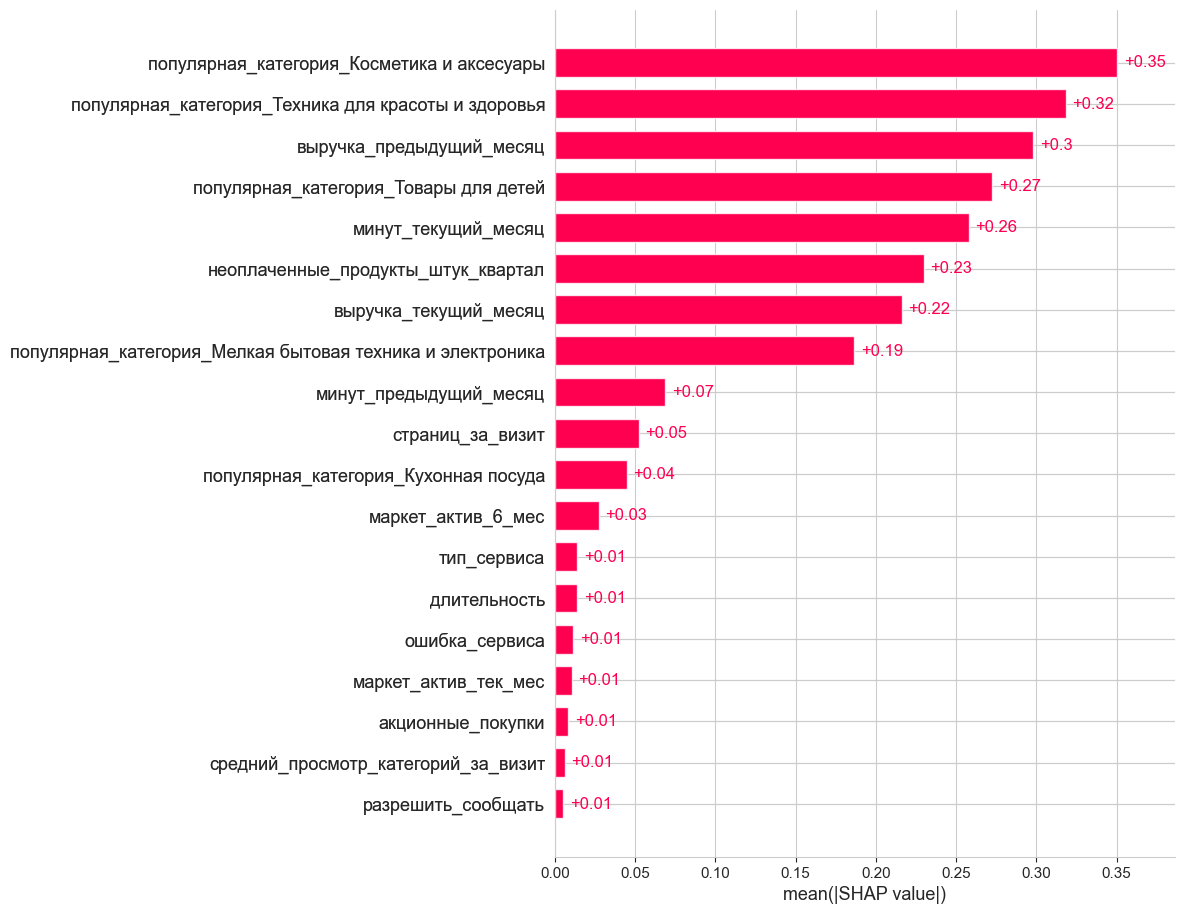

In [55]:
explainer = shap.LinearExplainer(best_model.named_steps['models'], X_train_transformed, feature_perturbation='interventional')

shap_values = explainer.shap_values(X_train_transformed)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_train_transformed,
    feature_names=feature_names
)

# Строим bar-график для первых 20 признаков
shap.plots.bar(shap_explanation, max_display=20)

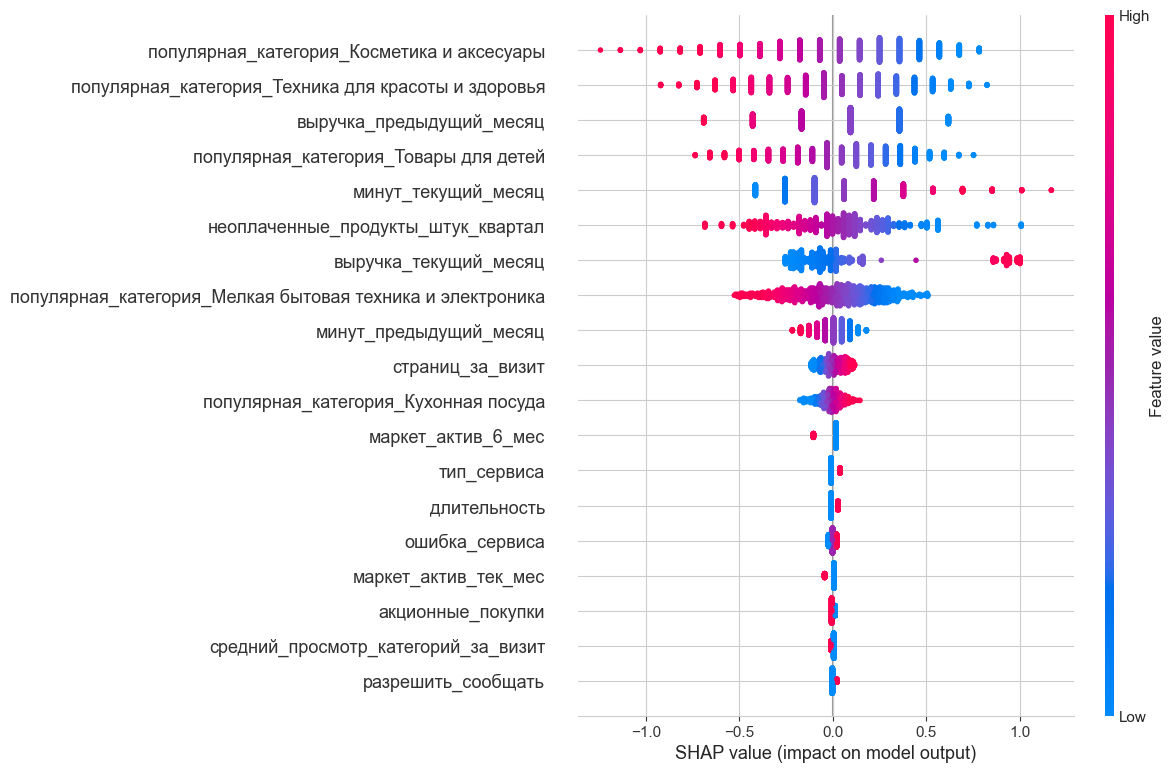

In [56]:
# Строим beeswarm-график для первых 20 признаков
shap.plots.beeswarm(shap_explanation, max_display=20)

Вывод по важности признаков: <br>
- Самый важный признаки - популярные категории <br>
- На втором месте - выручка в предыдущем месяце <br>
- На третьем месте - активность на сайте

Можно использовать эти наблюдения для моделирования и принятия бизнес-решений. 

### Сегментация покупателей

Добавим результаты предсказаний в исходный датафрейм

In [57]:
y_prob = best_model.predict_proba(X)
# Создаем столбец "Снижение покупательской активности в будущем" на основе порога 0.5
market['снижение_покупательской_активности_в_будущем'] = pd.Series(y_prob[:, 1]).apply(
    lambda x: 'Снизится' if x > 0.5 else 'Останется прежней'
)
market.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,снижение_покупательской_активности_в_будущем
1,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,Останется прежней
2,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,Снизится
3,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,Снизится
4,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,Снизится
5,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,Снизится


Сегментация клиентов на группы

<b>Группа 1</b> - Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. <br>
<b>Группа 2</b> - Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом. <br>
<b>Группа 3</b> - Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей». <br>
<b>Группа 4</b> - Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. <br>
<b>Группа 5</b> (новая) - Группа клиентов, активно использующих премиальные сервисы и с высокой вероятностью снижения покупательской активности. <br>

In [58]:
market.loc[(market['акционные_покупки'] > 0.5) & (market['снижение_покупательской_активности_в_будущем'] == 'Снизится'), 'группа'] = 'Группа 1'
market.loc[(market['тип_сервиса'] == 'техника'), 'группа'] = 'Группа 2'
market.loc[(market['популярная_категория'].isin(['товары для себя', 'товары для детей'])), 'группа'] = 'Группа 3'
market.loc[(market['снижение_покупательской_активности_в_будущем'] == 'Снизится') & (market['выручка_текущий_месяц'] > 5000), 'группа'] = 'Группа 4'
market.loc[(market['тип_сервиса'] == 'премиум') & (market['снижение_покупательской_активности_в_будущем'] == 'Снизится'), 'группа'] = 'Группа 5'

# Заполняем оставшиеся строки как "Другая"
market['группа'] = market['группа'].fillna('Другая')

market

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,снижение_покупательской_активности_в_будущем,группа
1,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,Останется прежней,Другая
2,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,Снизится,Группа 4
3,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,Снизится,Группа 4
4,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,Снизится,Группа 4
5,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,Снизится,Другая
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,0,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7,Снизится,Другая
1296,216644,0,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11,NaN,Другая
1297,216645,0,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18,NaN,Другая
1298,216646,0,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7,NaN,Другая


In [59]:
market['группа'].value_counts()

группа
Другая      972
Группа 5    149
Группа 4    136
Группа 1     39
Name: count, dtype: int64

Исследуем подробнее группу 4 (с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью). Так как они приносят больше всего прибыли, но снижают активность. Это изменение можно предсказать и предпринять меры для удержания клиентов.

In [60]:
market = market.merge(money, on='id', how='left')

market.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,снижение_покупательской_активности_в_будущем,группа,прибыль
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,5216.0,4472.0,4971.6,12,10,Останется прежней,Другая,4160.0
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,5457.5,4826.0,5058.4,8,13,Снизится,Группа 4,3130.0
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,6158.0,4793.0,6610.4,11,13,Снизится,Группа 4,4870.0
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,5807.5,4594.0,5872.5,8,11,Снизится,Группа 4,4210.0
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,4738.5,5124.0,5388.5,10,10,Снизится,Другая,3950.0


In [61]:
group_4 = market[market['группа'] == 'Группа 4']

group_4.describe()

,id,покупательская_активность,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,прибыль
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,215616.669118,0.919118,3.679412,4.022059,586.691176,0.468897,2.566176,3.882353,3.926471,4.654412,5578.279412,4703.801471,5906.549265,10.801471,10.272059,4023.235294
std,242.500433,0.273662,1.056557,0.714577,227.416228,0.303497,1.286409,2.277292,1.824250,3.144375,406.874249,254.400146,649.936690,3.083576,2.940060,986.846742
min,215350.000000,0.000000,0.900000,3.000000,135.000000,0.110000,1.000000,0.000000,1.000000,1.000000,5022.000000,4119.000000,3789.700000,5.000000,4.000000,1060.000000
25%,215462.250000,1.000000,3.000000,4.000000,444.750000,0.250000,2.000000,2.000000,2.000000,3.000000,5232.000000,4546.000000,5484.775000,8.750000,8.000000,3477.500000
50%,215578.500000,1.000000,3.800000,4.000000,578.000000,0.330000,2.000000,4.000000,4.000000,4.000000,5493.500000,4721.500000,5832.300000,10.000000,10.000000,4095.000000
75%,215666.000000,1.000000,4.400000,5.000000,760.250000,0.890000,3.000000,6.000000,5.000000,5.000000,5867.000000,4831.500000,6347.600000,12.250000,12.000000,4657.500000
max,216630.000000,1.000000,6.300000,5.000000,1064.000000,0.990000,6.000000,9.000000,8.000000,18.000000,6809.000000,5624.000000,7799.400000,19.000000,22.000000,6730.000000


In [62]:
counter_segment = market[(market['выручка_текущий_месяц'] > 5000) & 
                         (market['снижение_покупательской_активности_в_будущем'] == 'Останется прежней')]

counter_segment.describe()

,id,покупательская_активность,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,прибыль
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,216156.227700,0.129108,4.562441,3.995305,581.976526,0.244296,3.556338,2.326291,4.394366,9.436620,5445.940141,5027.424883,5787.650939,14.673709,14.265258,3964.084507
std,275.407022,0.335714,0.909685,0.685978,256.946539,0.179420,1.237785,1.510470,2.038308,3.448713,330.196051,323.097523,609.139485,3.526587,4.147012,1022.857236
min,215349.000000,0.000000,1.700000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,5004.000000,4273.000000,4704.400000,6.000000,4.000000,1370.000000
25%,215949.250000,0.000000,3.900000,4.000000,357.500000,0.150000,3.000000,1.000000,3.000000,7.000000,5180.500000,4795.750000,5339.600000,12.000000,12.000000,3215.000000
50%,216158.500000,0.000000,4.500000,4.000000,592.500000,0.205000,3.500000,2.000000,4.000000,9.000000,5363.500000,5042.000000,5647.350000,14.500000,14.000000,3980.000000
75%,216376.750000,0.000000,5.300000,4.000000,789.500000,0.260000,4.000000,3.000000,6.000000,12.000000,5649.875000,5267.750000,6137.550000,17.000000,17.000000,4670.000000
max,216641.000000,1.000000,6.600000,5.000000,1061.000000,0.990000,6.000000,7.000000,9.000000,19.000000,6588.500000,5637.000000,7557.000000,23.000000,23.000000,7020.000000


In [63]:
numerical_columns = group_4.select_dtypes(include=['int64', 'float64']).columns

group_4_mean = group_4[numerical_columns].mean()
counter_segment_mean = counter_segment[numerical_columns].mean()

difference = group_4_mean - counter_segment_mean
difference

id                                    -539.558582
маркет_актив_6_мес                      -0.883030
маркет_актив_тек_мес                     0.026754
длительность                             4.714651
акционные_покупки                        0.224601
средний_просмотр_категорий_за_визит     -0.990162
неоплаченные_продукты_штук_квартал       1.556062
ошибка_сервиса                          -0.467896
страниц_за_визит                        -4.782208
выручка_текущий_месяц                  132.339271
выручка_предыдущий_месяц              -323.623412
выручка_препредыдущий_месяц            118.898326
минут_текущий_месяц                     -3.872238
минут_предыдущий_месяц                  -3.993199
прибыль                                 59.150787
dtype: float64

Положительные значения означают, что у группы 4 этот показатель выше, а отрицательные — что ниже по сравнению с контрсегментом.

- Маркет_актив_6_мес (-0.88): За последние 6 месяцев группа 4 получает меньше маркетинговых коммуникаций, чем контрсегмент.

- Маркет_актив_тек_мес (0.03): В текущем месяце разница в маркетинговой активности минимальная, но немного в пользу группы 4.

- Длительность (4.71): Клиенты из группы 4 зарегистрированы на сайте дольше, чем клиенты контрсегмента. Это говорит о более долговременных отношениях с магазином.

- Акционные_покупки (0.22): Группа 4 делает больше акционных покупок, чем контрсегмент. Клиенты реагируют на скидки и акции, что может быть важно для их удержания.

- Средний_просмотр_категорий_за_визит (-0.99): Клиенты из группы 4 просматривают меньше категорий за один визит, чем контрсегмент. Это может указывать на узкую направленность покупок.

- Неоплаченные_продукты_штук_квартал (1.56): У группы 4 больше неоплаченных продуктов в корзине. Это потенциально указывает на потерянные продажи или трудности с завершением покупок.

- Ошибка_сервиса (-0.47): Группа 4 сталкивается с меньшим количеством ошибок сервиса, что позитивно сказывается на опыте клиентов.

- Страниц_за_визит (-4.78): Группа 4 просматривает значительно меньше страниц за один визит, чем контрсегмент. Это может свидетельствовать о меньшей заинтересованности в исследовании ассортимента.

- Выручка_текущий_месяц (132.34): В текущем месяце группа 4 приносит значительно больше выручки по сравнению с контрсегментом.

- Выручка_предыдущий_месяц (-323.62): В предыдущем месяце группа 4 принесла существенно меньше выручки.

- Выручка_препредыдущий_месяц (118.89): В предпредыдущем месяце выручка снова была выше для группы 4.

- Минут_текущий_месяц (-3.87) и Минут_предыдущий_месяц (-3.99): Клиенты группы 4 проводят меньше времени на сайте, что может говорить о целенаправленных покупках или снижении интереса.

- Прибыль (59.15): Группа 4 приносит больше прибыли, чем контрсегмент, что делает ее приоритетной для бизнеса.

#### Рекомендации для группы 4 <br>
- Группа 4 часто не завершает свои покупки до конца, оставляя товары в корзине. Можно стимулировать их к завершению покупки, например через уведомления или email. <br>
- Группа 4 активно реагирует на акции и скидки, можно активнее предлагать им промокоды на скидки для интересующих категорий <br>
- У группы 4 меньше проведённого времени на сайте, чем у остальных. Можно увеличить вовлечённость клиентов, чтобы они больше проводили времени на сайте => делали больше покупок. 

### Общий вывод <br>
В ходе исследования были проведены следующие шаги: <br>
- Были загружены и предобработаны данные из 4 csv файлов. <br>
- Проведен исследовательский анализ данных. <br>
- Данные объединены в один датафрейм. <br>
- Проведен корреляционный анализ. <br>
- Использованы пайплайны для обучения 4 моделей: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC. <br>
- Выбрана лучшая модель - Логистическая Регрессия с метрикой roc_auc 91.16%. <br>
- Выполнен анализ важности признаков с помощью SHAP. <br>
- Проведена сегментация покупателей. <br>

Задача состояла в том, чтобы разработать модель, которая предскажет вероятность снижения покупательской активности и выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. <br> Данные были загружены, предобработаны, объединены в один датафрейм. Проведен корреляционный анализ. Использованы пайплайны для обучения 4 моделей, с помощью RandomizedSearchCV была выбрана лучшая модель - Логистическая Регрессия с метрикой roc_auc 91.16%. Проведен анализ важности признаков с помощью SHAP. Проведена сегментация покупателей. <br> <br> Дополнительно был проведён анализ группы 4. <br> Для увеличения прибыли от группы 4 были предложены следующие действия: <br>
- Группа 4 часто не завершает свои покупки до конца, оставляя товары в корзине. Можно стимулировать их к завершению покупки, например через уведомления или email. <br>
- Группа 4 активно реагирует на акции и скидки, можно активнее предлагать им промокоды на скидки для интересующих категорий <br>
- У группы 4 меньше проведённого времени на сайте, чем у остальных. Можно увеличить вовлечённость клиентов, чтобы они больше проводили времени на сайте => делали больше покупок. 